In [38]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


# Gradient Boosting Libraries

In the previous class, we finished with implementing the classical **Adaptive Boosting** algorithm for binary classification. Essentially, this algorithm **greedy minimizes** specific exponential loss. The natural expansion of this idea is the **Gradient Boosting** algorithm, in which every new estimator is trained to move the loss toward its -gradient. We won't implement the **Gradient Boosting** algorithm as it will be a part of your next homework. Instead, today we will focus on available libraries and their APIs.

|                       | Scikit-Learn GradientBoostingX                                                                                 | XGBoost                                                                                             | LightGBM                                                                                               | CatBoost                                                                                               |
|-----------------------------|----------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------|
| **Developer**               | Scikit-Learn Community                                                                                         | DMLC                                                                                                | Microsoft                                                                                              | Yandex                                                                                                 |
| **Release Year**            | 2007                                                                                                           | 2014                                                                                                | 2016                                                                                                  | 2017                                                                                                   |
| **Tree Growth Strategy**    | Level-wise growth                                                                                             | Level-wise growth                                                                                   | Leaf-wise growth                                                                                       | Symmetric trees                                                                                        |
| **Categorical Feature Handling** | Requires manual preprocessing (e.g., one-hot encoding)                                                       | Requires preprocessing (e.g., one-hot encoding or label encoding)                                   | Supports categorical features with manual specification                                                | Native handling of categorical features                                                                |
| **Missing Value Handling**  | Requires manual imputation                                                                                     | Natively supports missing values                                                                    | Natively supports missing values                                                                       | Natively supports missing values                                                                       |
| **Training Speed**          | Generally slower compared to others                                                                            | Faster than Scikit-Learn but can be slower than LightGBM and CatBoost                               | Optimized for speed; typically faster on large datasets                                                | Competitive training speed; optimized for datasets with categorical features                           |
| **Regularization Techniques** | Supports L2 regularization and early stopping                                                                  | Supports L1 and L2 regularization, shrinkage, and early stopping                                    | Supports L1 and L2 regularization, early stopping, and exclusive feature bundling                      | Utilizes ordered boosting and L2 regularization to prevent overfitting                                 |
| **Parallel and GPU Support** | Supports parallelism; no native GPU support                                                                    | Supports parallel and distributed computing; GPU acceleration available                             | Supports parallel and distributed computing; optimized for GPU acceleration                            | Supports CPU and GPU training; optimized implementations for both                                       |

In [39]:
import os
import time
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import datasets
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor


import xgboost as xgb
import lightgbm as lgb
import catboost as cb

In [40]:
# TODO: choose dataset that is large enought to see perfomance difference
X, y = datasets.fetch_california_housing(return_X_y=True, as_frame=True)
feature_names = X.columns
X.head(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Sci-kit learn

In [42]:
gb_regressor = GradientBoostingRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42
)

hist_regressor = HistGradientBoostingRegressor(
    early_stopping=False, max_iter=200, learning_rate=0.1, max_depth=3, random_state=42
)

In [43]:
%%time
gb_regressor.fit(X_train, y_train)

CPU times: user 4.51 s, sys: 1.86 ms, total: 4.51 s
Wall time: 4.52 s


GradientBoostingRegressor(n_estimators=200, random_state=42)

In [44]:
%%time

# No sort!
hist_regressor.fit(X_train, y_train)

CPU times: user 427 ms, sys: 1.08 ms, total: 429 ms
Wall time: 65.8 ms


HistGradientBoostingRegressor(early_stopping=False, max_depth=3, max_iter=200,
                              random_state=42)

In [45]:
gb_train_pred = gb_regressor.predict(X_train)
gb_test_pred = gb_regressor.predict(X_test)
hist_train_pred = hist_regressor.predict(X_train)
hist_test_pred = hist_regressor.predict(X_test)

In [46]:
# Calculate evaluation metrics
def print_metrics(name, y_train, y_test, train_pred, test_pred):
    print(f"\n{name} Performance:")
    print(f"Train explained variance: {r2_score(y_train, train_pred):.4f}")
    print(f"Test explained variance: {r2_score(y_test, test_pred):.4f}")
    print(f"Train MSE: {mean_squared_error(y_train, train_pred):.2f}")
    print(f"Test MSE: {mean_squared_error(y_test, test_pred):.2f}")
    print(f"Train MAE: {mean_absolute_error(y_train, train_pred):.2f}")
    print(f"Test MAE: {mean_absolute_error(y_test, test_pred):.2f}")


print_metrics("Gradient Boosting", y_train, y_test, gb_train_pred, gb_test_pred)
print_metrics("HistGradient Boosting", y_train, y_test, hist_train_pred, hist_test_pred)


Gradient Boosting Performance:
Train explained variance: 0.8359
Test explained variance: 0.8004
Train MSE: 0.22
Test MSE: 0.26
Train MAE: 0.33
Test MAE: 0.35

HistGradient Boosting Performance:
Train explained variance: 0.8326
Test explained variance: 0.8066
Train MSE: 0.22
Test MSE: 0.25
Train MAE: 0.33
Test MAE: 0.34


### Feature Importances

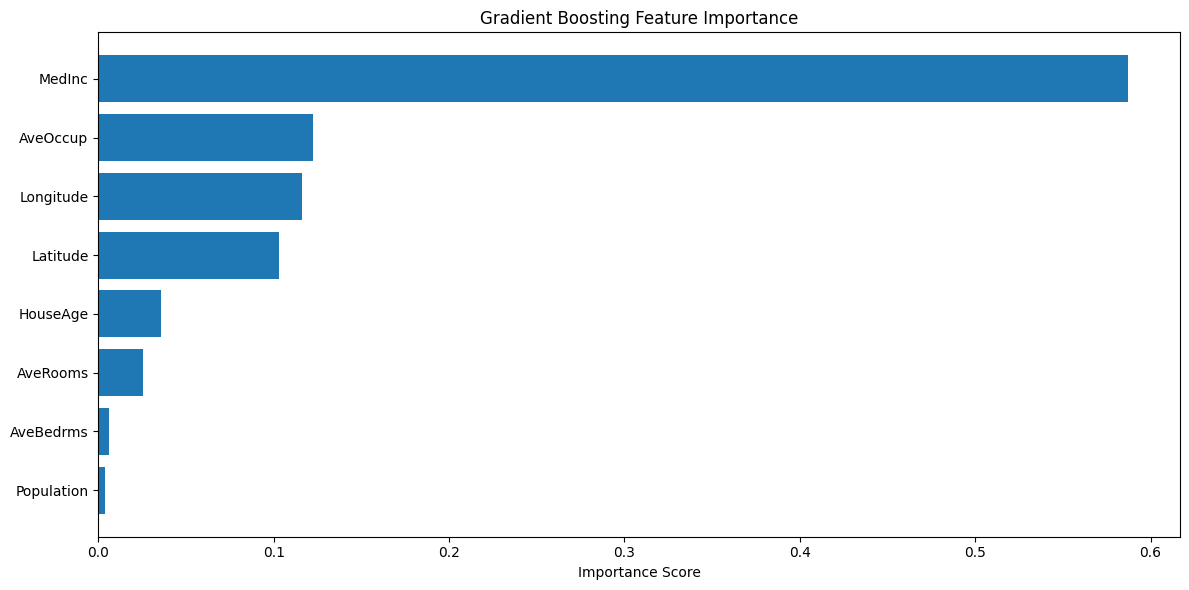

In [47]:
plt.figure(figsize=(12, 6))

## TODO: how feature importances are calculated in GMB??
sorted_idx = gb_regressor.feature_importances_.argsort()
plt.barh(
    np.array(feature_names)[sorted_idx], gb_regressor.feature_importances_[sorted_idx]
)
plt.title("Gradient Boosting Feature Importance")
plt.xlabel("Importance Score")

# NO IMPORTANCES FOR HIST GB!
# plt.subplot(1, 2, 2)
# sorted_idx = hist_regressor.feature_importances_.argsort()
# plt.barh(np.array(feature_names)[sorted_idx], hist_regressor.feature_importances_[sorted_idx])
# plt.title("HistGradient Boosting Feature Importance")
# plt.xlabel("Importance Score")

plt.tight_layout()
plt.show()

For HistGradientBoosting we can use black-box importance estimators, and they are oftern preferred over impurity-based importances.

> What are the problems with impurity-based importances?

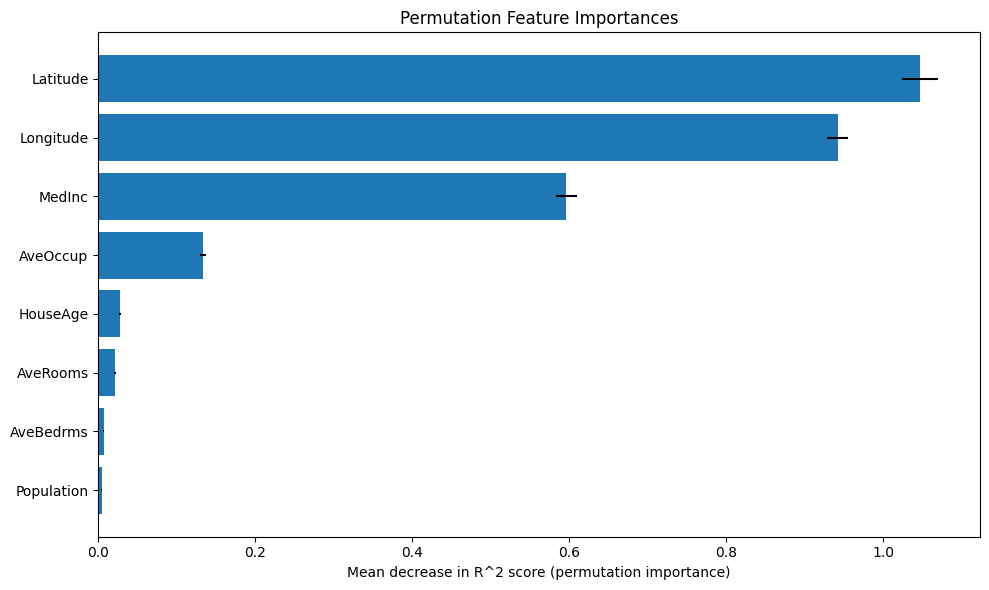

In [48]:
result = permutation_importance(
    hist_regressor, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Sort and plot
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(
    range(len(sorted_idx)),
    result.importances_mean[sorted_idx],
    xerr=result.importances_std[sorted_idx],
    align="center",
)
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Mean decrease in R^2 score (permutation importance)")
plt.title("Permutation Feature Importances")
plt.tight_layout()
plt.show()

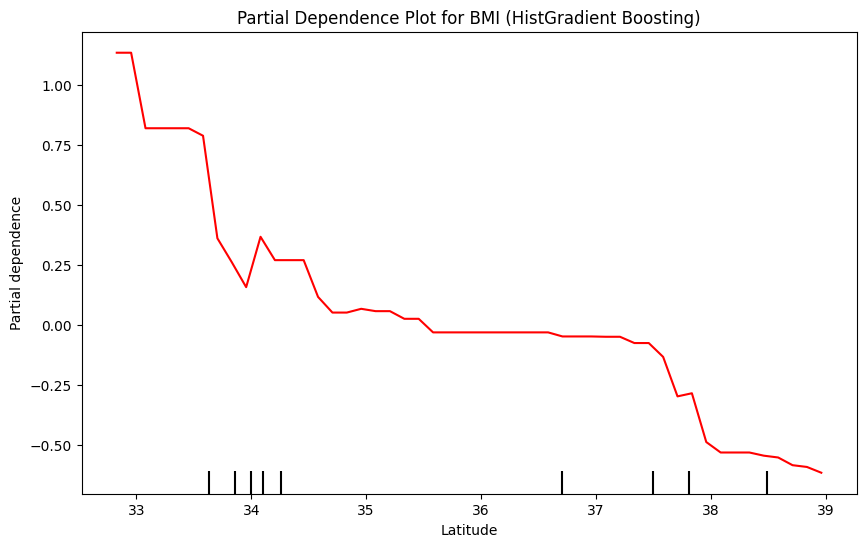

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    hist_regressor,
    X_train,
    features=[np.where(np.array(feature_names) == "Latitude")[0][0]],
    ax=ax,
    grid_resolution=50,
    line_kw={"color": "red"},
)
plt.title("Partial Dependence Plot for BMI (HistGradient Boosting)")
plt.show()

### Trees

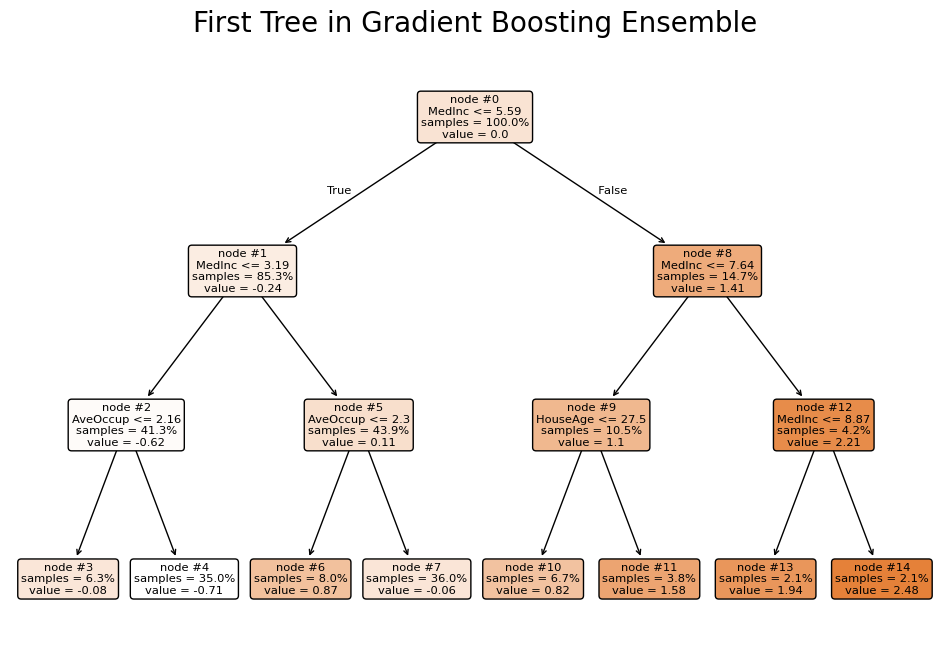

In [50]:
N = 1
plt.figure(figsize=(12, 8))

plot_tree(
    gb_regressor.estimators_[1, 0],
    feature_names=feature_names,
    filled=True,
    rounded=True,
    proportion=True,
    node_ids=True,
    impurity=False,
    precision=2,
)
plt.title("First Tree in Gradient Boosting Ensemble", fontsize=20)
plt.show()

### Learning Curves

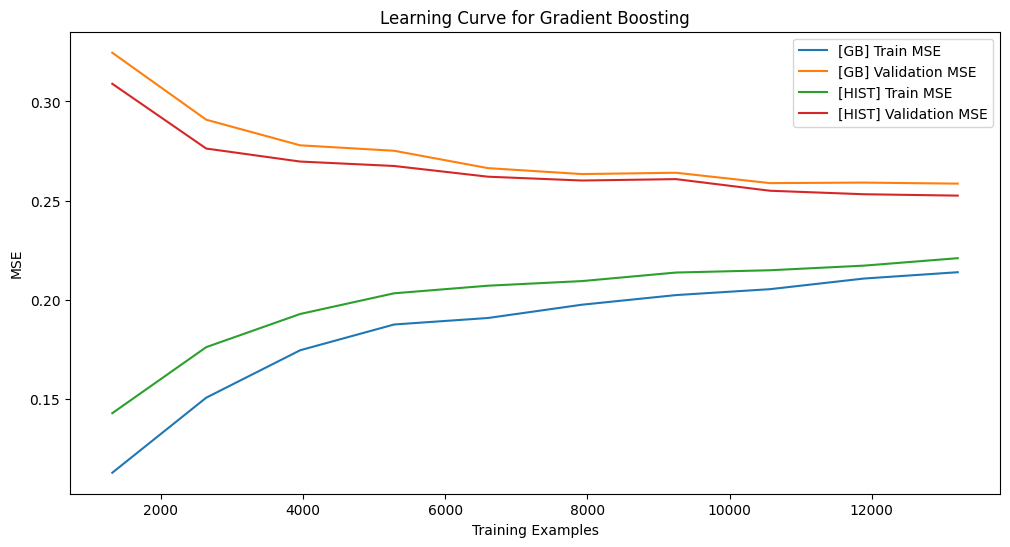

In [51]:
from sklearn.model_selection import learning_curve

# TODO: unfit before running

gb_train_sizes, gb_train_scores, gb_test_scores = learning_curve(
    gb_regressor,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
)

hist_train_sizes, hist_train_scores, hist_test_scores = learning_curve(
    hist_regressor,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
)


plt.figure(figsize=(12, 6))

plt.plot(gb_train_sizes, -gb_train_scores.mean(axis=1), label="[GB] Train MSE")
plt.plot(gb_train_sizes, -gb_test_scores.mean(axis=1), label="[GB] Validation MSE")

plt.plot(hist_train_sizes, -hist_train_scores.mean(axis=1), label="[HIST] Train MSE")
plt.plot(
    hist_train_sizes, -hist_test_scores.mean(axis=1), label="[HIST] Validation MSE"
)

plt.xlabel("Training Examples")
plt.ylabel("MSE")
plt.title("Learning Curve for Gradient Boosting")
plt.legend()
plt.show()

## XGBoost

In [52]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    alpha=0.1,
    # lambda=0.1,
    random_state=42,
)

In [53]:
%%time
# Train the model
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],  # Validation data
    verbose=False,
)

CPU times: user 6.15 s, sys: 19 ms, total: 6.17 s
Wall time: 392 ms


XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, ...)

In [54]:
# Make predictions
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

print_metrics("XGBoost", y_train, y_test, pred_train, pred_test)


XGBoost Performance:
Train explained variance: 0.8679
Test explained variance: 0.8216
Train MSE: 0.18
Test MSE: 0.23
Train MAE: 0.29
Test MAE: 0.32


### Feature Importance

Feature Importances:
MedInc: 0.4942
HouseAge: 0.0636
AveRooms: 0.0792
AveBedrms: 0.0332
Population: 0.0155
AveOccup: 0.1360
Latitude: 0.0864
Longitude: 0.0920


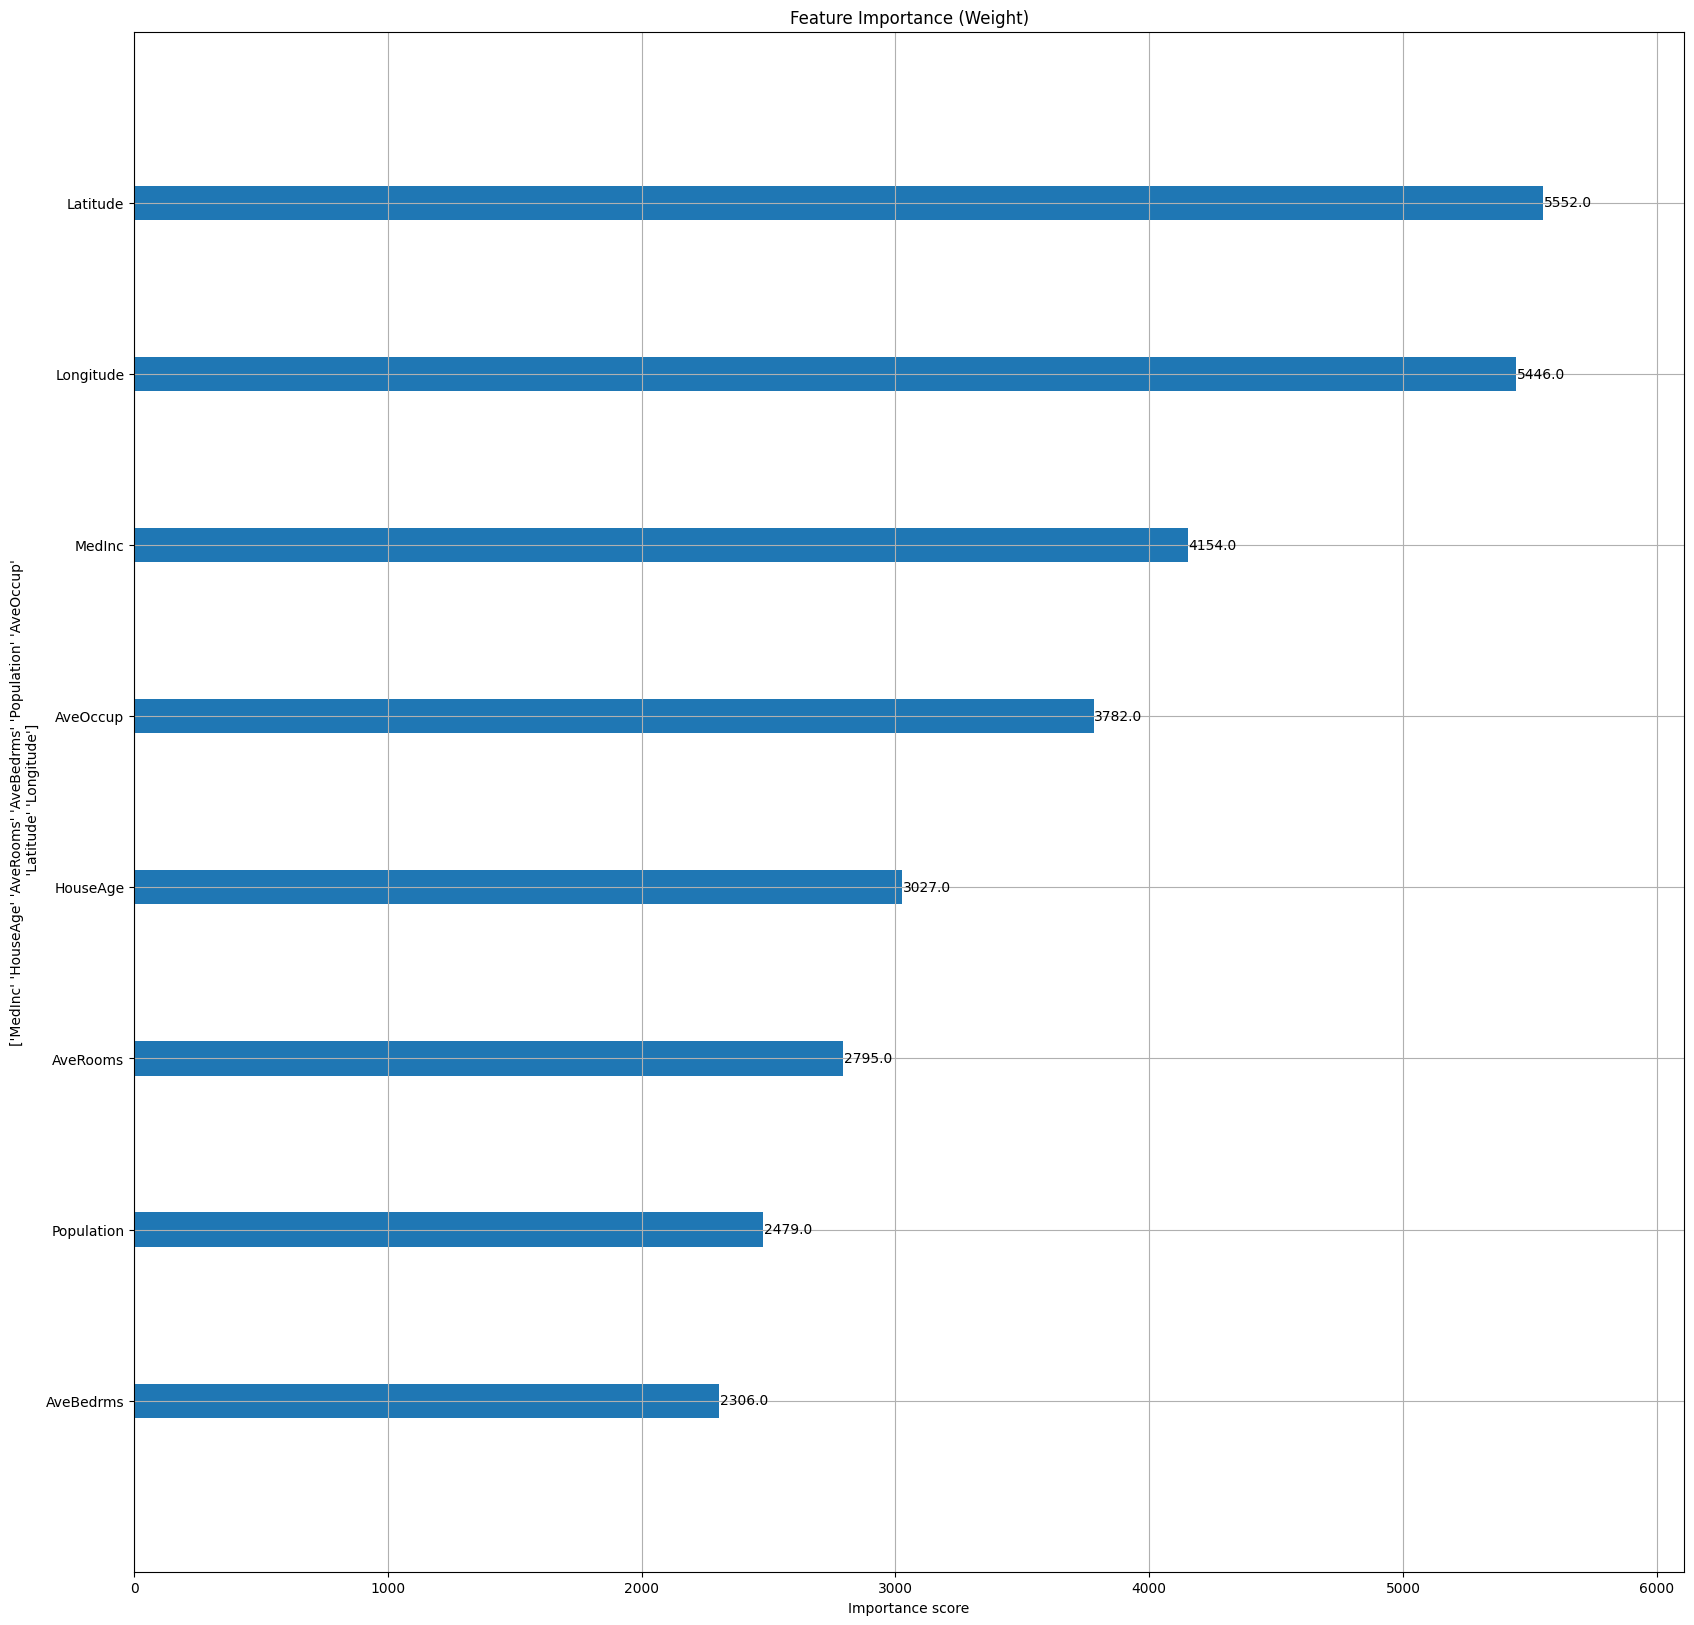

In [55]:
print("Feature Importances:")
for name, score in zip(feature_names, model.feature_importances_):
    print(f"{name}: {score:.4f}")

plt.rcParams["figure.figsize"] = (20, 20)
xgb.plot_importance(model, importance_type="weight", ylabel=np.array(feature_names))
plt.title("Feature Importance (Weight)")
plt.show()

/home/succ_seed/work/studies/pyvenv/py3.10/lib/python3.10/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

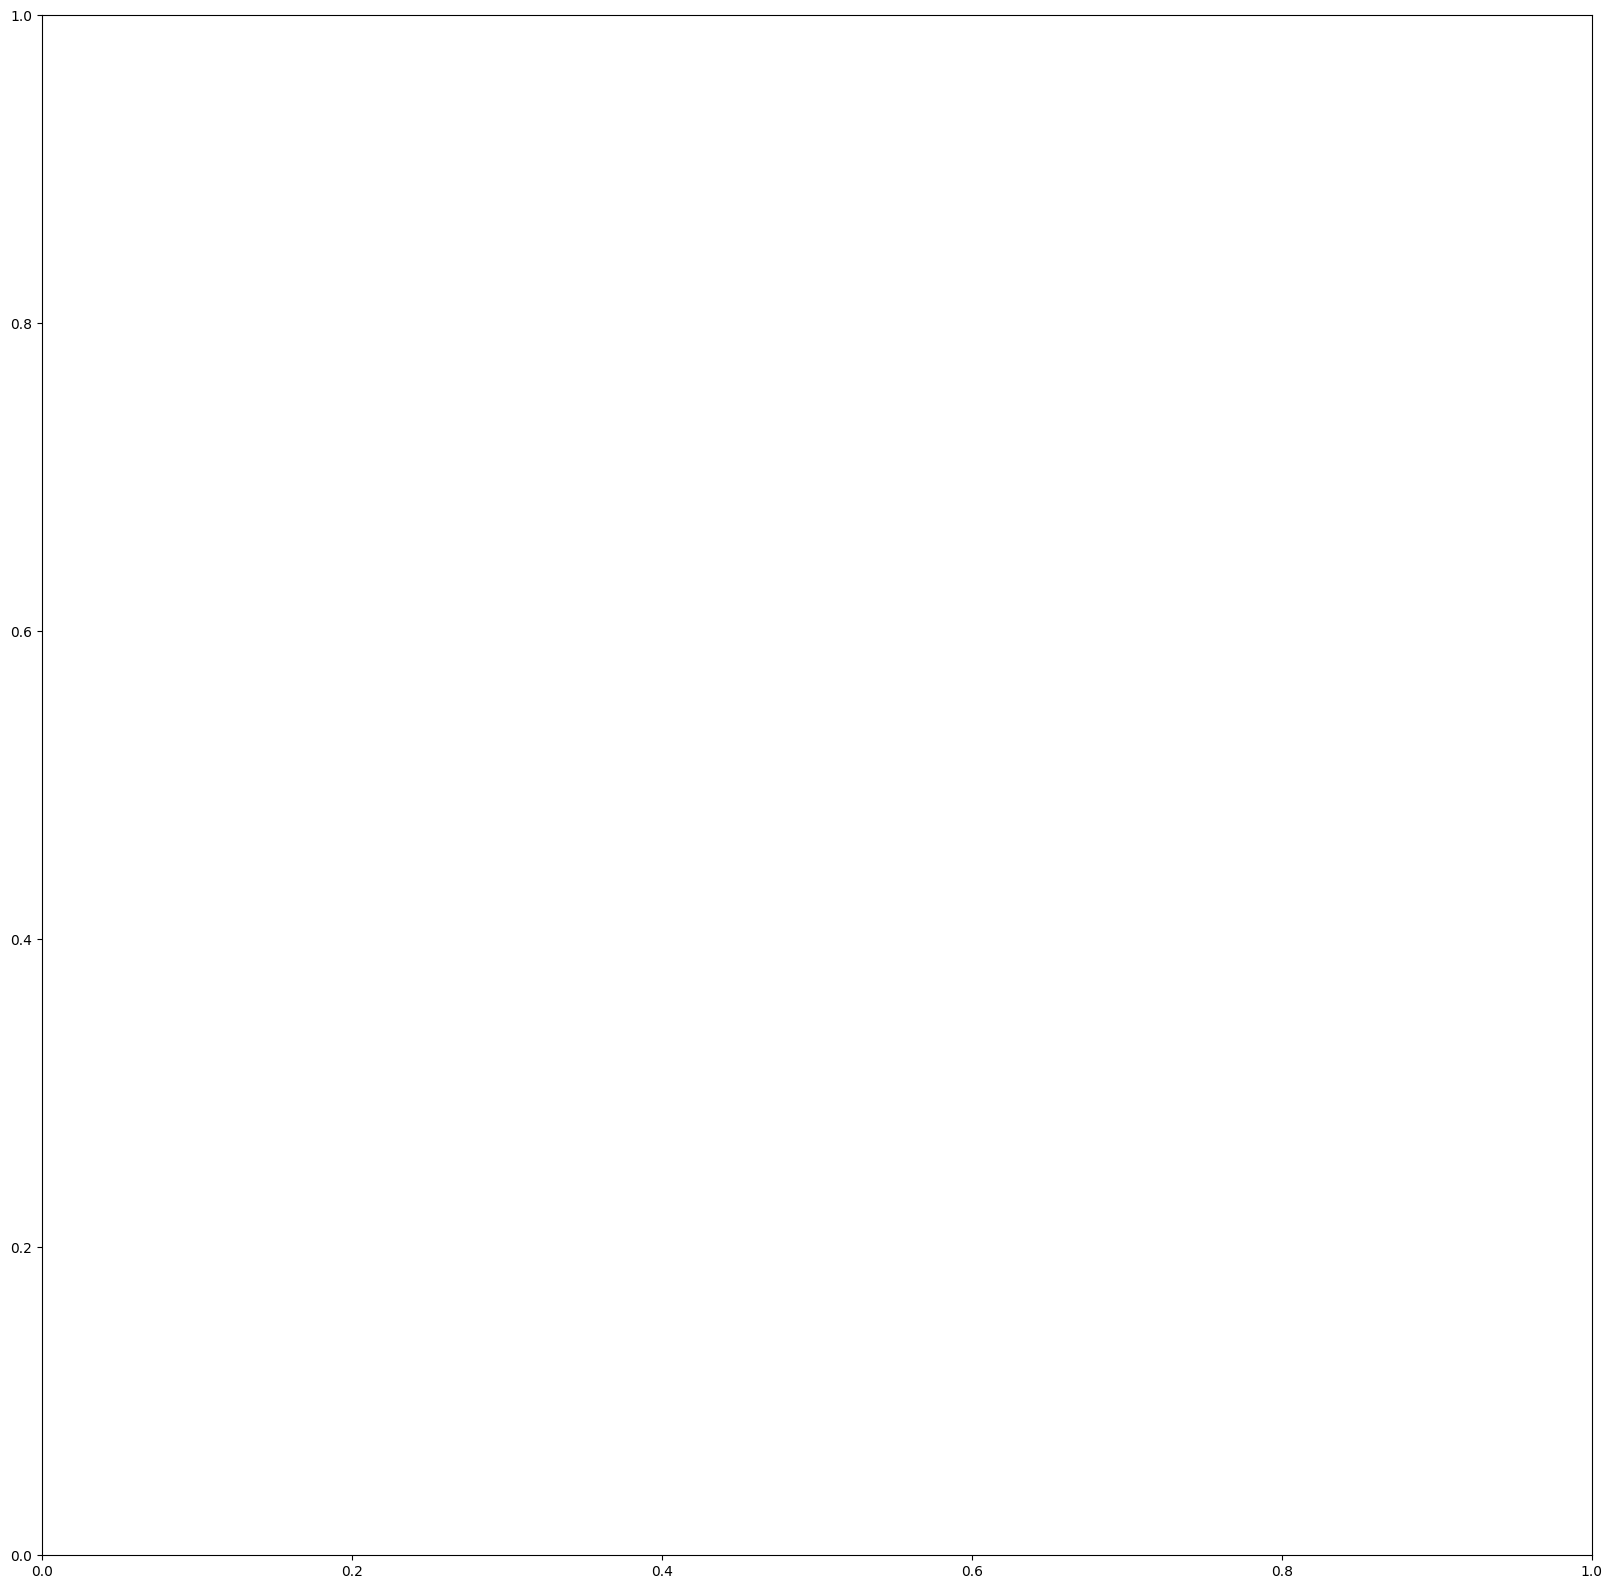

In [56]:
xgb.plot_tree(model, num_trees=0, rankdir="LR")
plt.title("First Tree in Model")
plt.show()

In [ ]:
# dataset wrappers
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "max_depth": 5,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "alpha": 0.1,
    "lambda": 0.1,
}

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    nfold=5,
    metrics={"rmse"},
    early_stopping_rounds=50,
    seed=42,
    as_pandas=True,
)

In [ ]:
print("\nCross-Validation Results:")
print(cv_results.tail())
print(f"\nBest RMSE: {cv_results['test-rmse-mean'].min():.4f}")

# Plot training history
results = model.evals_result()
plt.figure(figsize=(10, 6))
plt.plot(results["validation_0"]["rmse"], label="Validation RMSE")
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("Training History")
plt.legend()
plt.show()

In [ ]:
# Save model
model.save_model("xgb_regression_model.json")

# Load model for later use
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("xgb_regression_model.json")

# LightGBM

In [ ]:
# Dataset Wrappers!
train_data = lgb.Dataset(X_train, label=y_train, feature_name=feature_names.tolist())
test_data = lgb.Dataset(
    X_test, label=y_test, reference=train_data, feature_name=feature_names.tolist()
)

In [ ]:
%%time

params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "random_state": 42,
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=["train", "valid"],
    num_boost_round=1000,
)

In [ ]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print_metrics("LGB", y_train, y_test, pred_train, pred_test)

In [ ]:
# Feature Importance Analysis
importance_df = pd.DataFrame(
    {
        "feature": feature_names,
        "split_importance": model.feature_importance(importance_type="split"),
        "gain_importance": model.feature_importance(importance_type="gain"),
    }
).sort_values("gain_importance", ascending=False)

print("\nFeature Importance Table:")
print(importance_df)

# Visualizations
plt.figure(figsize=(12, 8))

# Feature Importance Plot (Gain-based)
lgb.plot_importance(
    model,
    importance_type="gain",
    max_num_features=10,
    title="Gain-based Feature Importance",
)
plt.xlabel("Importance Score")
plt.ylabel("Features")

In [ ]:
# number of times feature is used to split
lgb.plot_importance(
    model,
    importance_type="split",
    max_num_features=10,
    title="Split-based Feature Importance",
)
plt.xlabel("Importance Score")
plt.ylabel("Features")

In [ ]:
# Decision Tree Visualization
ax = plt.subplot(2, 2, 4)
lgb.plot_tree(model, tree_index=3, ax=ax, figsize=(18, 12))
plt.title("Example Decision Tree Structure")
plt.tight_layout()
plt.show()

## CatBoost

In [ ]:
# pools for efficient memory handling
train_pool = cb.Pool(X_train, y_train)
test_pool = cb.Pool(X_test, y_test)

In [ ]:
model = cb.CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function="RMSE",
    eval_metric="R2",
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100,
)

In [ ]:
%%time
model.fit(
    train_pool,
    eval_set=test_pool,
    plot=True,  # Displays live training metrics in notebook
)

In [ ]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print_metrics("CatBoost", y_train, y_test, pred_train, pred_test)

In [ ]:
feature_importance = model.get_feature_importance()

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title("Feature Importance")
plt.show()

In [ ]:
results = model.evals_result_
plt.figure(figsize=(10, 6))
plt.plot(results["learn"]["RMSE"], label="Train RMSE")
plt.plot(results["validation"]["RMSE"], label="Validation RMSE")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Training History")
plt.legend()
plt.show()

In [ ]:
pd.DataFrame(results).explode(["learn", "validation"])

In [ ]:
## TODO: this is broken
model.plot_tree(tree_idx=24, pool=train_pool)
plt.title("First Tree Structure")
plt.show()

In [ ]:
# Cross-validation
cv_params = model.get_params()
cv_data = cb.cv(train_pool, cv_params, fold_count=5, plot=True, verbose=False)

In [ ]:
# Save model
model.save_model("catboost_regression_model.cbm")

# Load model for prediction
loaded_model = cb.CatBoostRegressor()
loaded_model.load_model("catboost_regression_model.cbm")

# Bonus tasks 29-31

Today's bonus tasks can be completed only by 1-2 students per task. If you want to participate, DM me in Telegram **before Sunday, 23:59.** If more than 8 people want to participate, I will choose those with fewer stars. Each task costs 2 points, if 2 students share one task, they achieve 1 point each.

The task is to prepare a detailed presentation (20 mins) on each of these algorithms. 

* **Bonus Task 29:** [XGBoost](https://arxiv.org/abs/1603.02754)
* **Bonus Task 30:** [LightGBM](https://papers.nips.cc/paper_files/paper/2017/hash/6449f44a102fde848669bdd9eb6b76fa-Abstract.html)
* **Bonus Task 21:** [CatBoost](https://arxiv.org/abs/1706.09516)

Your presentation should cover the details of each algorithm, including the proofs where applicable. Implementation from scratch is not required.